In [1]:
#|default_exp accel

# Denoising Diffusion Probabilistic Models with miniai

## Imports

In [2]:
#|export
import pickle,gzip,math,os,time,shutil,torch,random,logging
import fastcore.all as fc,matplotlib as mpl,numpy as np,matplotlib.pyplot as plt
from collections.abc import Mapping
from pathlib import Path
from functools import partial

from fastcore.foundation import L
import torchvision.transforms.functional as TF,torch.nn.functional as F
from torch import tensor,nn,optim
from torch.utils.data import DataLoader,default_collate
from torch.nn import init
from torch.optim import lr_scheduler

from miniai.datasets import *
from miniai.conv import *
from miniai.learner import *
from miniai.activations import *
from miniai.init import *
from miniai.sgd import *
from miniai.resnet import *
from miniai.augment import *

In [3]:
from torcheval.metrics import MulticlassAccuracy
from datasets import load_dataset,load_dataset_builder

mpl.rcParams['image.cmap'] = 'gray_r'
logging.disable(logging.WARNING)

## Load the dataset

In [4]:
xl,yl = 'image','label'
name = "fashion_mnist"
dsd = load_dataset(name)

@inplace
def transformi(b): b[xl] = [F.pad(TF.to_tensor(o), (2,2,2,2)) for o in b[xl]]

bs = 128
tds = dsd.with_transform(transformi)
dls = DataLoaders.from_dd(tds, bs, num_workers=8)

  0%|          | 0/2 [00:00<?, ?it/s]

In [5]:
dt = dls.train
xb,yb = next(iter(dt))

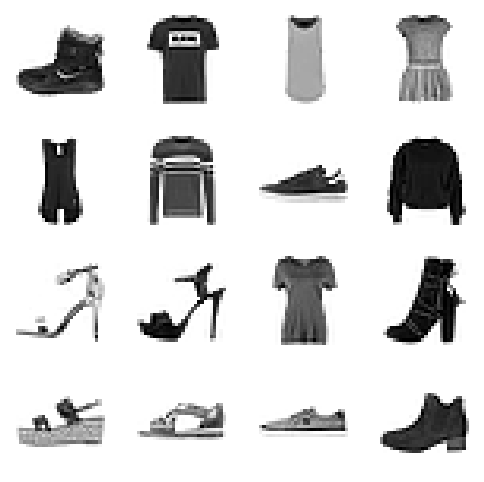

In [6]:
show_images(xb[:16], imsize=1.5)

$\beta$, the variance, is one of the variables that describes the diffusion process. 
$\beta(t)$ increases as $t$ increases:  $\beta(t) > \beta(t-1)$.
As $t$ increases the mean $\mu$ decreases, and we get less of the original image $x_0$.
As $\mu \rightarrow 0$, $\beta$ keeps increasing,
we lose contribution from $x_0$ as $t$ increases.
The iterative process keeps adding noise, and ends with the image $x_T$ being "PureNoise".

JH: Its useful to consider one extreme, at $x_1$ $\mu = (1-\beta(t)) * x_0$.
$(1-\beta_t) \rightarrow 1$.
At $x_1$ the mean is close to $x_0$ and the variance $\beta$ is very small.
Hence $x_1$ is the $x_0$ image that just has a tiny bit of noise.
<br>
Sometimes is easier to write $q(x_t)$ directly because these are all independent.
$q(x_t)$ is only dependent of $x_{t-1}$, which is only dependent on $x_{t-2}$.
Each of the $x_{t-i}$ steps are independent.
So based on the laws of probabilities we can get $q(x_t)$ in close form.

In [7]:
betamin,betamax,n_steps = 0.0001,0.02,1000
β = torch.linspace(betamin, betamax, n_steps)
α = 1.-β
ᾱ  = α.cumprod(dim=0)
σ = β.sqrt()

Lets plot these variables to better understand them.
$\beta$ is linenspace, a line with 1000 `t` points equally spaced from `betamin=0.0001` 
to `betamax=0.02`.

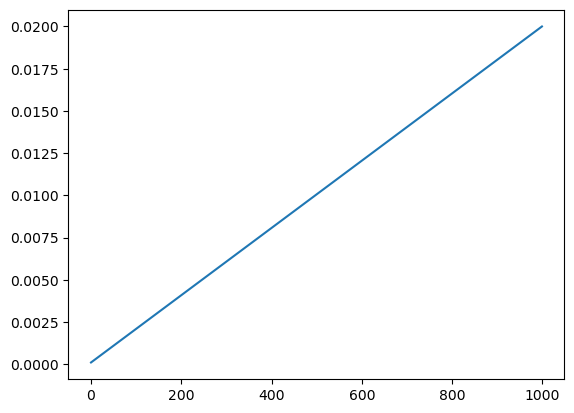

In [8]:
plt.plot(β);

$\sigma = \sqrt\beta$ 

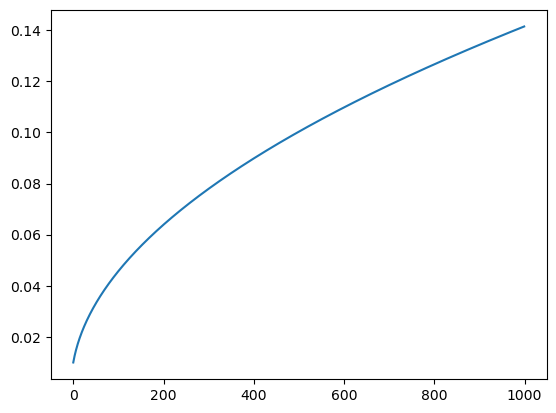

In [9]:
plt.plot(σ);

ᾱ is the "cumulative product" `cumprod` of $1-\beta$.

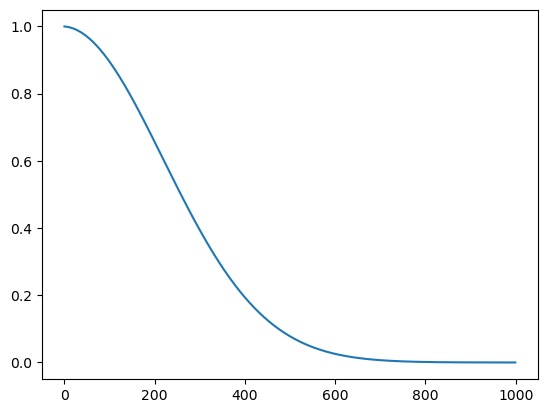

In [10]:
plt.plot(ᾱ);

JH copied and pasted from notebook 15_ `before_batch` and created `noisify`.
This forces us to figure out what are the arguments to `noisify`:
an image `x0` and $\bar{\alpha}$ (alphabar).
We could get $\bar{\alpha}$ but to be flexible we pass it in.

In [11]:
def noisify(x0, ᾱ, n_steps=1000):
    device = x0.device
    n = len(x0)
    t = torch.randint(0, n_steps, (n,), dtype=torch.long)
    ε = torch.randn(x0.shape, device=device)
    ᾱ_t = ᾱ[t].reshape(-1, 1, 1, 1).to(device)
    xt = ᾱ_t.sqrt()*x0 + (1-ᾱ_t).sqrt()*ε
    return (xt, t.to(device)), ε

Now we experiment with `noiseify` on the first 25 images.
Notice that each image gets a different (random) timestamp `t`.
We print out the actual chosen `t` and use them as titles for the images.

In [12]:
(xt,t),ε = noisify(xb[:25],ᾱ)
t

tensor([799, 102, 216, 129, 130, 138, 400, 224, 851,  11, 472, 269, 371, 480,
        685, 268, 995, 201, 739, 576, 807, 240, 480, 479, 567])

NB: Sometimes in the particular set below none of the images look like anything,
e.g., when all the `t`s are over 200, it's almost impossible to see anything.
If so, rerun `noisify` to get a better sample of images. <br>
`t=0` is the pure (original) image, `t<10` is just a slightly speckled image,
by `t>60` it's a bad image, eventually it's hard to see what it is...
<br>
`fc.map` is an extended version of `map` in fastcore. 
If we pass it a string (rather than a function) it calls the `{}` to format the string.
That is how we get the `titles`.

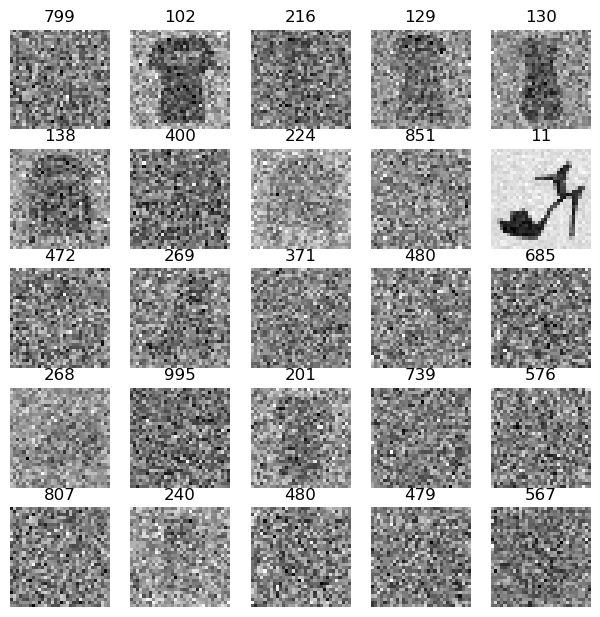

In [13]:
titles = fc.map_ex(t, '{}')
show_images(xt, imsize=1.5, titles=titles)

## Training

In [14]:
from diffusers import UNet2DModel

Took the `sample` method (in notebook 15_) and turned it into a separate `sample()` function,
and pass in everything that it needs.
(we could calculate them, but since we already did, lets just pass them in.)
`torch.full(size, fill_value, *, out=None, dtype=None, layout=torch.strided, device=None, requires_grad=False) → Tensor`  creates a tensor of size size filled with fill_value. 

In [15]:
@torch.no_grad()
def sample(model, sz, alpha, alphabar, sigma, n_steps):
    device = next(model.parameters()).device
    x_t = torch.randn(sz, device=device)
    preds = []
    for t in reversed(range(n_steps)):
        t_batch = torch.full((x_t.shape[0],), t, device=device, dtype=torch.long)
        z = (torch.randn(x_t.shape) if t > 0 else torch.zeros(x_t.shape)).to(device)
        ᾱ_t1 = alphabar[t-1]  if t > 0 else torch.tensor(1)
        b̄_t = 1 - alphabar[t]
        b̄_t1 = 1 - ᾱ_t1
        x_0_hat = ((x_t - b̄_t.sqrt() * learn.model((x_t, t_batch)))/alphabar[t].sqrt()).clamp(-1,1)
        x_t = x_0_hat * ᾱ_t1.sqrt()*(1-alpha[t])/b̄_t + x_t * alpha[t].sqrt()*b̄_t1/b̄_t + sigma[t]*z
        preds.append(x_t.cpu())
    return preds

The Callback is now tiny: `before_batch` is just a call to `noiseify` 
and the `sample` method just calls the `sample` function.
<br>
We want to try many different ways of doing this as an exercise 
see all the ways we can work with our framework.
Decided not to inherit from `trainCB` but instead inherited from `Callback`.
Hence we can't use notebook 15_ trick of replacing `predict()`.
Instead we now need a way to pass-in the two parts of the first element of the Tuple
as separate things to the model and return the sample.

In [16]:
class DDPMCB(Callback):
    order = DeviceCB.order+1
    def __init__(self, n_steps, beta_min, beta_max):
        fc.store_attr()
        self.beta = torch.linspace(self.beta_min, self.beta_max, self.n_steps)
        self.α = 1. - self.beta 
        self.ᾱ = torch.cumprod(self.α, dim=0)
        self.σ = self.beta.sqrt()
    
    def before_batch(self, learn): learn.batch = noisify(learn.batch[0], self.ᾱ)
    def sample(self, model, sz): return sample(model, sz, self.α, self.ᾱ, self.σ, self.n_steps)

We can inherit from [Unet2DModel](https://huggingface.co/docs/diffusers/api/models#diffusers.UNet2DModel)
and replace the `forward` method, by calling the original `UNet2DModel` `forward`, 
passing `*x`, and returning that `.sample`.
Then we don't need `trainCB` and we don't need to replace `predict`.

In [17]:
class UNet(UNet2DModel):
    def forward(self, x): return super().forward(*x).sample

If we're not working with miniai we can always replace the model,
such that it has the interface that we need.

We create the `DDPMCB` callback `ddpm_cb`.

In [18]:
ddpm_cb = DDPMCB(n_steps=1000, beta_min=0.0001, beta_max=0.02)

When we create the `model` we use our `UNet`. 
To speed-up JH divided all `block_out_channels` by 2 and found it works well.
Noticed that  `Unet2DModel` uses `GroupNorm`, which splits the channels 
into a number of groups, each must have more than one channel. 
We can actually pass in how many groups we want `norm_num_groups` to use in the normalization.
NB: Be careful. At first got an error msg "can't split 16 things into 32 groups".
<br>
We want to look at the results of `noiseify` as we call `fit()`.
But we don't call the training part of the `fit` and use the `SingleBatchCB` callback.
`learn.batch` will contain a tuple of tuples. 
We'd expect the images to look the same as before.
<br>
Always draw pictures of everything along the way.
Early experiments are likely wrong, pictures illustrate how it's wrong (or right) until it's fixed.

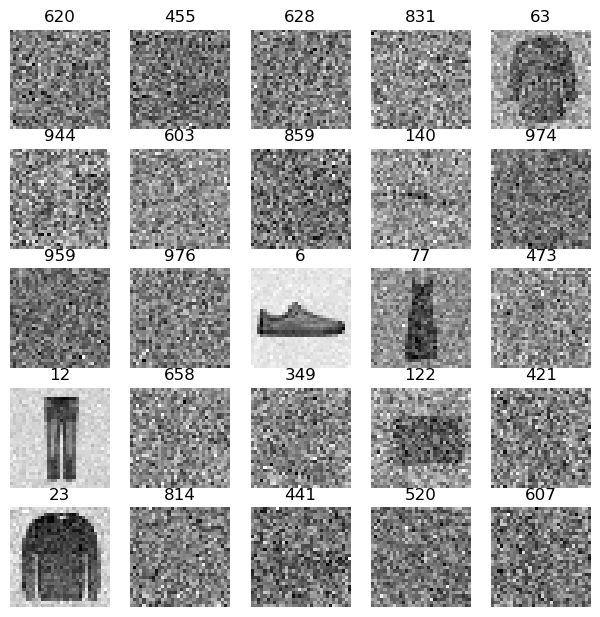

In [19]:
model = UNet(in_channels=1, out_channels=1, block_out_channels=(16, 32, 64, 64), norm_num_groups=8)

learn = TrainLearner(model, dls, nn.MSELoss())
learn.fit(train=False, cbs=[ddpm_cb,SingleBatchCB()])
(xt,t),ε = learn.batch
show_images(xt[:25], titles=fc.map_ex(t[:25], '{}'), imsize=1.5)

To make it train faster we want to use a higher Learning Rate `lr`.

In [20]:
lr = 5e-3
epochs = 5

tmax = epochs * len(dls.train)
sched = partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax)
cbs = [ddpm_cb, DeviceCB(), ProgressCB(plot=True), MetricsCB(), BatchSchedCB(sched)]

In [21]:
model = UNet(in_channels=1, out_channels=1, block_out_channels=(16, 32, 64, 128), norm_num_groups=8)

NB: The diffusers code does not initialize anything! HF just uses the Pytorch defaults. :(
But these defaults aren't ideal for every model, as they depend on what activation function we have, etc.
<br>
JH wasn't sure how to initialize it, by chatting and looking at papers, ended up doing a few things
in `init_ddpm`.
One is to take every second convolutional layer (they are called conv2 inside the resnets) 
and zero it out.
we could do the same thing with using batchNorm.
Since we've got a deep ANN seemed that having the non-id path in the resnets
do nothing at first so they can't cause problems.
<br>
To understand using an [orthogonal matrix](https://en.wikipedia.org/wiki/Orthogonal_matrix)  for weights requires computational linear algebra background.
Using [init.orthogonal_](https://pytorch.org/docs/stable/nn.init.html#torch.nn.init.orthogonal_) weights for the down samples is a good idea.
For the `model.up_blocks` to set the second columns to `data.zero_`.
Also useful from a (Google paper) is to zero out the weights of the very last layer:
`model.conv_out.weight.data.zero_()`.
It will start by predicting zero as the noise which can't hurt.

In [22]:
def init_ddpm(model):
    for o in model.down_blocks:
        for p in o.resnets:
            p.conv2.weight.data.zero_()
            for p in fc.L(o.downsamplers): init.orthogonal_(p.conv.weight)

    for o in model.up_blocks:
        for p in o.resnets: p.conv2.weight.data.zero_()

    model.conv_out.weight.data.zero_()

In [23]:
init_ddpm(model)

Replacing the normal `Adam` Optimizer with one that has an `eps=1e-5` made a big difference.
When we divide by the exponentially weighted moving average of the squared gradients.
If it is a very small number then it makes the effective learning rate huge.
So we add an `eps` to it to make the effect on the lr not too huge.
The default is too small, good idea is to make it bigger.
Prior to this change using a reasonably large lr exploded around the middle of the one cycle training.
Trained, got ~0.016 after 5 epochs, samplies look similar. 

In [24]:
opt_func = partial(optim.Adam, eps=1e-5)
learn = TrainLearner(model, dls, nn.MSELoss(), lr=lr, cbs=cbs, opt_func=opt_func)

loss,epoch,train
0.147,0,train
0.027,0,eval
0.023,1,train
0.022,1,eval
0.020,2,train
0.020,2,eval
0.019,3,train
0.018,3,eval
0.018,4,train
0.019,4,eval


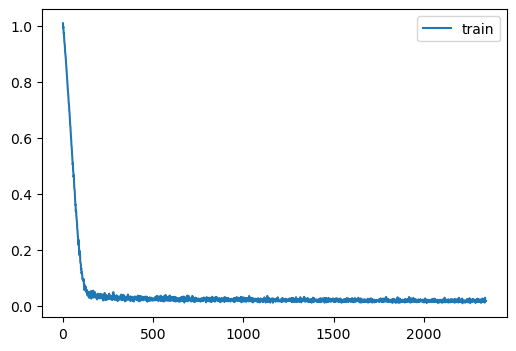

In [25]:
learn.fit(epochs)

In [26]:
mdl_path = Path('models')

In [27]:
torch.save(learn.model, mdl_path/'fashion_ddpm2.pkl')

In [28]:
learn.model = torch.load(mdl_path/'fashion_ddpm2.pkl')

## Sampling

In [29]:
samples = ddpm_cb.sample(learn.model, (16, 1, 32, 32))

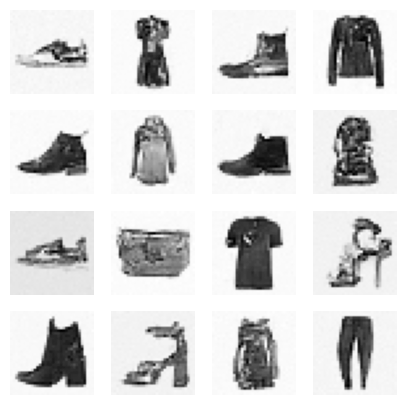

In [30]:
show_images(samples[-1], figsize=(5,5))

## Mixed Precision
To make it faster we can use mixed Precision. 
Currently we're using the default 32-bit floating Point values.
GPUs are much faster at doing 16-bit floating Point values.
16-bit floating Point values aren't able to represent a wide range of numbers 
or much precision at the difference between numbers.
But if we can use them we benefit because modern GPUs 
have special units that do Matrix multiplies of 16-bit values extremely quickly.
We can't just cast everything to 16-bit because then there's not enough precision 
to calculate gradients properly.
So we use mixed precision, use 32-bit where we need 32-bit and 16-bit for things we can.

In [31]:
bs = 512

In [32]:
next(iter(DataLoader(tds['train'], batch_size=2)))

{'image': tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]]],
 
 
         [[[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]]]]),
 'label': tensor([9, 0])}

We can put `noiseify` inside a collation function, `collate_ddpm(b)`. 
A collation function turns the data into a tensor representing the independent variable 
one tensor representing either the dependent variable.
`collate_ddpm` will call `default_collate` on the batch `b`,
and then grabs the `[x]` part which is `image` (the dataset uses dictionaries).
We grab the images and call `noiseify` on that collated batch.
(The same thing as notebook 15_ `before_batch`.)
`before_batch` is operating on the thing that came out of the `default_collect` function.
We define a ddpm dataloader `dl_ddpm` function which creates a dataloader from some dataset `ds`.
We pass-in a batch size `bs`, with the `collation_ddpm` function.
Then we can create our `dls` not using the `dataloaders_from_dd`,
but instead we use the original `Dataloader`, where we just pass in 
the dataloaders for `train` and `test`,
and we don't need a ddpm callback anymore.

In [33]:
def collate_ddpm(b): return noisify(default_collate(b)[x], alphabar)
def dl_ddpm(ds): return DataLoader(ds, batch_size=bs, collate_fn=collate_ddpm, num_workers=4)

In [34]:
dls = DataLoaders(dl_ddpm(tds['train']), dl_ddpm(tds['test']))

The `MixedPrecision` callback is a `TrainCB` callback.
[Pytorch mixed precision](https://pytorch.org/docs/stable/notes/amp_examples.html) docs 
show typical mixed Precision examples:
```Python
# Runs the forward pass with autocasting.
        with autocast(device_type='cuda', dtype=torch.float16):
            output = model(input)
            loss = loss_fn(output, target)
```
This is a context manager, starts calling `__enter__` and when it finishes it calls `__exit__`.
We can put the `torch.autocast` into an attribute and call `__enter__` in `before_batch`.
After we've calculated the loss we want to finish that context manager, 
so `after_loss` we call `__exit__`.

Pytorch doc indicates code that has to be run for mixed precision.
Instead of calling `loss.backwards` we call `scalar.scale(learn.loss).backward()`.
The doc indicates that when we do the step instead of `optimizer.step` we call 
`scalar.step(learn.opt)` and  `scalar.update`.
So we replace `step` with `scalar.step` `scalar.update`.

With the `MixedPrecision` class we don't have to think about any of those details.
We can add `MixedPrecision` to anything. 

In [35]:
#|export
class MixedPrecision(TrainCB):
    order = DeviceCB.order+10
    
    def before_fit(self, learn): self.scaler = torch.cuda.amp.GradScaler()

    def before_batch(self, learn):
        self.autocast = torch.autocast("cuda", dtype=torch.float16)
        self.autocast.__enter__()

    def after_loss(self, learn): self.autocast.__exit__(None, None, None)
        
    def backward(self, learn): self.scaler.scale(learn.loss).backward()

    def step(self, learn):
        self.scaler.step(learn.opt)
        self.scaler.update()

`cbs` no longer has a `ddpmcb` but has `MixedPrecision`, which is a `TrainCB`,
so we need a normal Learner (not a trained learner).

To benefit from MixedPrecision we need to do quite a bit at a time, the GPU needs to be busy.
With something as small as fashion mnist it's not easy to keep a GPU busy.
So we increased the batch size by four times, which means that each epoch is going to have 
four times less batches because they're bigger, hence it's got four times less opportunities to update.
That's got to be a problem because if we want to have as good a result as before, in less time.
we need to increase the learning rate and increase the epochs.
We increase epochs from 5 to 8, and increase the learning rate up to 1e-2

In [36]:
lr = 1e-2
epochs = 8
tmax = epochs * len(dls.train)
sched = partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax)
cbs = [DeviceCB(), MixedPrecision(), ProgressCB(plot=True), MetricsCB(), BatchSchedCB(sched)]
model = UNet(in_channels=1, out_channels=1, block_out_channels=(16, 32, 64, 128), norm_num_groups=8)
init_ddpm(model)
learn = Learner(model, dls, nn.MSELoss(), lr=lr, cbs=cbs, opt_func=opt_func)

In [39]:
learn.fit(epochs)

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ /var/folders/d0/mqk8_wqx39j87cld43llgktm0000gn/T/ipykernel_68488/4219247620.py:1 in <module>     │
│                                                                                                  │
│ [Errno 2] No such file or directory:                                                             │
│ '/var/folders/d0/mqk8_wqx39j87cld43llgktm0000gn/T/ipykernel_68488/4219247620.py'                 │
│                                                                                                  │
│ /Users/germangoldszmidt/GitHub/course22p2/nbs/miniai/learner.py:136 in fit                       │
│                                                                                                  │
│   133                                                                                            │
│   134 # %% ../nbs/09GC_learner.ipynb 20                                                          │
│   135 class with_cbs:                                                                            │
│ ❱ 136 │   def __init__(self, nm): self.nm = nm                                                   │
│   137 │   def __call__(self, f):                                                                 │
│   138 │   │   def _f(o, *args, **kwargs):                                                        │
│   139 │   │   │   try:                                                                           │
│                                                                                                  │
│ /Users/germangoldszmidt/GitHub/course22p2/nbs/miniai/learner.py:114 in one_epoch                 │
│                                                                                                  │
│   111 # %% ../nbs/09GC_learner.ipynb 18                                                          │
│   112 class ProgressCB(Callback):                                                                │
│   113 │   order = MetricsCB.order+1                                                              │
│ ❱ 114 │   def __init__(self, plot=False): self.plot = plot                                       │
│   115 │   def before_fit(self, learn):                                                           │
│   116 │   │   learn.epochs = self.mbar = master_bar(learn.epochs)                                │
│   117 │   │   self.first = True                                                                  │
│                                                                                                  │
│ /Users/germangoldszmidt/mambaforge/lib/python3.9/site-packages/fastprogress/fastprogress.py:50   │
│ in __iter__                                                                                      │
│                                                                                                  │
│    47 │   │   │   │   self.update(self.total)                                                    │
│    48 │   │   except Exception as e:                                                             │
│    49 │   │   │   self.on_interrupt()                                                            │
│ ❱  50 │   │   │   raise e                                                                        │
│    51 │                                                                                          │
│    52 │   def update(self, val):                                                                 │
│    53 │   │   if self.last_v is None:                                                            │
│                                                                                                  │
│ /Users/germangoldszmidt/mambaforge/lib/python3.9/site-packages/fastprogress/fastprogress.py:41   │
│ in __iter__                                                                                      │
│                                                            

It trains fine with the proper initialization and with the optimization function w/eps change.
It trains even though it's doing more epochs, trains about twice as fast and gets the same result.

In [ ]:
samples = sample(learn.model, (64, 1, 32, 32), alpha, alphabar, sigma, n_steps)

In [ ]:
show_images(samples[-1][:25], imsize=1.5)

In [ ]:
torch.save(learn.model, mdl_path/'fashion_ddpm_mp.pkl')

## Accelerate

`pip install accelerate` before running this section.

The Accelerate library from huggingface (created by Sylvain), provides an accelerator to speed-up training.
Supports training with mixed precision, multiple GPUs and TPUs.

In [ ]:
#|export
from accelerate import Accelerator

Lets define a `TrainCB` subclass, `AccelerateCB`.
We create an accelerator, `acc`, tell it what kind of `mixed_precision` to use, e.g., `fp16`.
`before_fit` we call `acc.prepare()`, pass-in a model, optimizer, training and validation dataloaders.
It returns all of them wrapped up in accelerate, which will automatically do all requirements.
We also need to change the `loss` function to use accelerate, so we 
change `backward`, (that's why we inherit from `trainCB`), to call `self.acc.backward(learn.loss)`.

In [ ]:
#|export
class AccelerateCB(TrainCB):
    order = DeviceCB.order+10
    def __init__(self, n_inp=1, mixed_precision="fp16"):
        super().__init__(n_inp=n_inp)
        self.acc = Accelerator(mixed_precision=mixed_precision)
        
    def before_fit(self, learn):
        learn.model,learn.opt,learn.dls.train,learn.dls.valid = self.acc.prepare(
            learn.model, learn.opt, learn.dls.train, learn.dls.valid)

    def backward(self, learn): self.acc.backward(learn.loss)

Noisify change:
Rather than returning a couple of tuples, just return a tuple with 3 things: `xt, t.to(device), ε`.
Prefer to have 3 things in the Tuple and not have to modify the the model, 
nor modify the training callback, avoid anything tricky.
We want to have a custom collation function but don't want to have it modify the model.

In [ ]:
def noisify(x0, ᾱ):
    device = x0.device
    n = len(x0)
    t = torch.randint(0, n_steps, (n,), dtype=torch.long)
    ε = torch.randn(x0.shape, device=device)
    ᾱ_t = ᾱ[t].reshape(-1, 1, 1, 1).to(device)
    xt = ᾱ_t.sqrt()*x0 + (1-ᾱ_t).sqrt()*ε
    return xt, t.to(device), ε

In [ ]:
dls = DataLoaders(dl_ddpm(tds['train']), dl_ddpm(tds['test']))

We need to take the `.sample` out, so we define `DDPMCB2(Callback)`.
After the predictions are done replace them with `.sample` 

In [ ]:
class DDPMCB2(Callback):
    def after_predict(self, learn): learn.preds = learn.preds.sample

Lets go back to using a `UNet2Dmodel`.
But how to use a UNet2Dmodel when we have 3 things?
Modified `trainCB` (notebook 09) to add a parameter `n_inp`, number of inputs to the model.
By default we expect one input `n_inp=1`, but this model has two inputs.

We call `AccelerateCB(n_inp=2)`, it will remember how many inputs we asked.
When we call `predict` it is going to pass `*learn.batch[:self.n_inp]`.
Ditto when we call the loss function it's going to be `*learn.batch[self.n_inp:]`.
This way we can as many inputs/outputs.
We need to make sure that the model and the loss function take the number of parameters.
The loss function takes the preds and however many `n_inp` we have.

The only thing we need is noiseify, the collation function and `DDPMCB2`. 

In [ ]:
model = UNet2DModel(in_channels=1, out_channels=1, block_out_channels=(16, 32, 64, 128), norm_num_groups=8)
init_ddpm(model)
cbs = [DDPMCB2(), DeviceCB(), ProgressCB(plot=True), MetricsCB(), BatchSchedCB(sched), AccelerateCB(n_inp=2)]
learn = Learner(model, dls, nn.MSELoss(), lr=lr, cbs=cbs, opt_func=opt_func)

We do `learn.fit()` and we get the same result.
Takes the same amount of time because we are not using multi-GPU or GPU, just using mixed Precision.
It is just a shortcut, to enable the use of other types of (multiple) accelerators.

In [ ]:
learn.fit(epochs)

## A sneaky trick
To speed up the data loading and transformation process lets define `MultiDL`,
a new dataloader class which wraps an existing dataloader and replaces `__iter__`.
When we call it goes through the dataloader `dl`, 
and then i from 0 to `mult` (by default) 2, and then spit out the batch.
It will spit out the batch `mult` times.
Then every epoch is going to be `mult` times (eg twice) as long. 
It is going to load and augment the data as often as one epoch, 
but give us `mult` epochs worth of updates.
There's no reason to have a whole new batch every time, looking at the same batch 2-4 times at a row is fine.
What happens is you look at that batch you do an update, get ready a part of the weight space,
look at the same batch and find out now where to go in the weight space.

In [ ]:
class MultDL:
    def __init__(self, dl, mult=2): self.dl,self.mult = dl,mult
    def __len__(self): return len(self.dl)*self.mult
    def __iter__(self):
        for o in self.dl:
            for i in range(self.mult): yield o

In [ ]:
dls.train = MultDL(dls.train)

## Export -

In [ ]:
import nbdev; nbdev.nbdev_export()